In [1]:
#imports
from PIL import Image
import numpy as np
import os
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

#constants
# PATH_OF_CSV = './data/simulator/driving_log.csv'
PATH_OF_CSV = 'driving_log.csv'
IMAGE_TYPE = 'center'


In [2]:
# read CSV data
def readCsv():
    data = []
    with open(PATH_OF_CSV) as F:
        reader = csv.reader(F)
        for i in reader:
            data.append(i) 
    print('{0} images available in training data'.format(len(data)))
    #print("Imported {0} rows from CSV".format(len(data)))
    return data



In [3]:
### This function will resize the images from front, left and
### right camera to 18 x 80 and turn them into lists.
### The length of the each list will be 18 x 80 = 1440
### j = 0,1,2 corresponds to center, left, right
def load_image(csvRow, jj):
    image = plt.imread(csvRow[jj].strip())[65:135:4,0:-1:4,0]
    image_list = image.flatten().tolist()
    return image_list

csvData = readCsv()
load_image(csvData[0], 1)

8036 images available in training data


[211,
 206,
 205,
 207,
 202,
 200,
 203,
 203,
 187,
 196,
 190,
 191,
 178,
 169,
 152,
 165,
 151,
 177,
 173,
 176,
 173,
 191,
 165,
 152,
 142,
 160,
 168,
 147,
 179,
 130,
 0,
 0,
 4,
 1,
 7,
 149,
 177,
 183,
 185,
 188,
 186,
 191,
 189,
 211,
 203,
 200,
 183,
 193,
 175,
 33,
 0,
 16,
 136,
 32,
 169,
 54,
 185,
 169,
 165,
 209,
 188,
 199,
 60,
 35,
 30,
 49,
 34,
 44,
 36,
 193,
 13,
 176,
 189,
 169,
 182,
 183,
 116,
 139,
 161,
 145,
 155,
 157,
 155,
 156,
 165,
 164,
 168,
 170,
 173,
 173,
 167,
 137,
 153,
 153,
 151,
 142,
 141,
 140,
 148,
 148,
 0,
 0,
 0,
 0,
 14,
 1,
 11,
 0,
 5,
 0,
 8,
 8,
 187,
 181,
 194,
 195,
 200,
 205,
 207,
 209,
 212,
 217,
 220,
 215,
 215,
 214,
 206,
 212,
 201,
 223,
 199,
 6,
 0,
 18,
 22,
 7,
 0,
 6,
 0,
 0,
 5,
 7,
 6,
 159,
 158,
 143,
 29,
 35,
 50,
 22,
 190,
 35,
 178,
 163,
 40,
 43,
 164,
 172,
 166,
 197,
 158,
 150,
 157,
 157,
 142,
 152,
 136,
 149,
 126,
 139,
 140,
 20,
 0,
 11,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 12

In [4]:
from tqdm import tqdm

features = ()
labels = ()

# For each item in data, convert camera images to single list
# and save them into features list.
for i in tqdm(range(int(len(csvData))), unit='items'):
    for j in range(3):
        features += (load_image(csvData[i],j),)

item_num = len(features)
print("features size", item_num)


100%|██████████| 8036/8036 [02:57<00:00, 45.28items/s]    | 1/8036 [00:00<27:54,  4.80items/s]

features size 24108


In [5]:
# A single list will be convert back to the original image shapes.
# Each list contains 3 images so the shape of the result will be
# 54 x 80 where 3 images aligned vertically.
features = np.array(features).reshape(item_num, 18, 80, 1)
print("features shape", features.shape)

features shape (24108, 18, 80, 1)


In [6]:
### Save labels    
for i in tqdm(range(int(len(csvData))), unit='items'):
    for j in range(3):
        labels += (float(csvData[i][3]),)

labels = np.array(labels)

print("features:", features.shape)
print("labels:", labels.shape)

100%|██████████| 8036/8036 [00:00<00:00, 9953.93items/s]  | 2784/8036 [00:00<00:00, 27824.17items/s]

features: (24108, 18, 80, 1)
labels: (24108,)


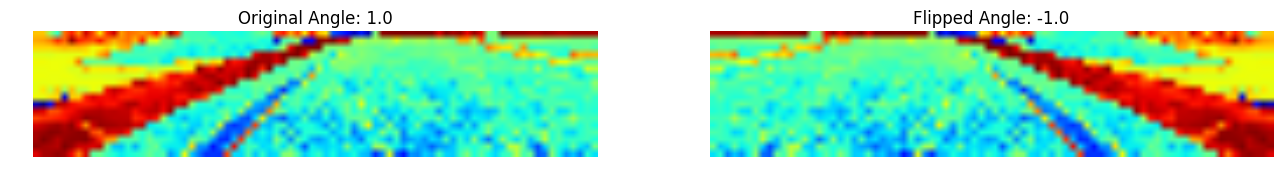

In [10]:
# flip image
def flip(image, steering_angle):
    return np.fliplr(image), -1 * steering_angle

def flip_allimages(image_array, angle_array):
    newfeatures = []
    newlabels = []
    for feature, label in zip(image_array, angle_array):
        flipped_image, flipped_angle = flip(feature, label)
        newfeatures.append(flipped_image)
        newlabels.append(flipped_angle)
    return np.concatenate((image_array, newfeatures)), np.concatenate((angle_array, newlabels))

# test flip
def test_flip(image_array, angle_array):
    y_train_max = np.argmax(angle_array)
    X_train_max, Y_train_max = flip(image_array[y_train_max], angle_array[y_train_max])
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(np.squeeze(image_array[y_train_max], axis=2))
    plt.title('Original Angle: {}'.format(angle_array[y_train_max]))
    plt.subplot(1,2, 2)
    plt.axis('off')
    plt.title('Flipped Angle: {}'.format(Y_train_max))
    plt.imshow(np.squeeze(X_train_max, axis=2))

test_flip(features, labels)
features, labels = flip_allimages(features, labels)
    

In [11]:
## truncate zero angles
# def truncateZeros(features, labels):
#     skip = 0
#     count = 0
#     newfeatures = []
#     newlabels = []
#     for feature, label in zip(features, labels):
#         if label == 0:
#             if count > skip:
#                 count = 0
#                 newfeatures.append(feature)
#                 newlabels.append(label)
#             else:
#                 count = count + 1
#         else:
#             newfeatures.append(feature)
#             newlabels.append(label)

#     return np.array(newfeatures), np.array(newlabels)
            
                
# features, labels = truncateZeros(features, labels)
    

In [12]:
def plotRandomImage(image_array, angle_array):
    X_random_16 = np.random.choice(len(image_array), 8)
    plt.figure(figsize=(16,6))
    for ii,idx in enumerate(X_random_16):
        plt.subplot(4,4, ii+1)
        plt.axis('off')
        plt.title('Angle: {}'.format(angle_array[idx]))
        plt.imshow(np.squeeze(image_array[idx], axis=2))

#create histogram of y
#display min,max steering and image
def plotMinMax(image_array, angle_array):
    y_train_min = np.argmin(angle_array)
    y_train_max = np.argmax(angle_array)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(np.squeeze(image_array[y_train_min], axis=2))
    plt.title('Minimum Angle: {}'.format(angle_array[y_train_min]))
    plt.subplot(1,2, 2)
    plt.axis('off')
    plt.title('Maximum Angle: {}'.format(angle_array[y_train_max]))
    plt.imshow(np.squeeze(image_array[y_train_max], axis=2))

    
def plotYHistorygram(labels):
    plt.figure()
    hist = plt.hist(labels, bins=51, alpha=0.5)
    plt.title("Histogram with 'auto' bins")
    plt.show()        
    print(hist)


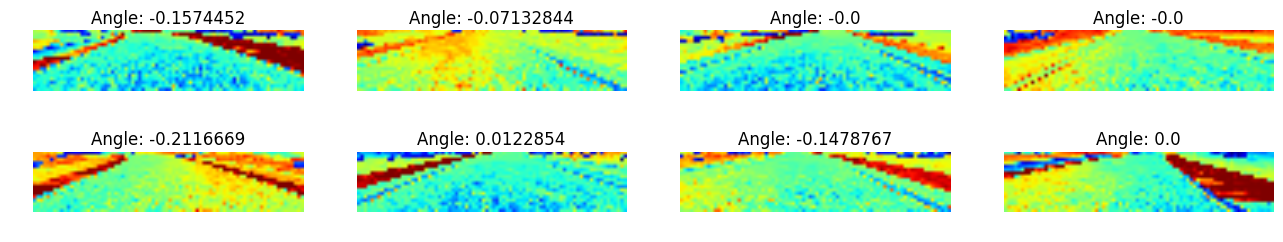

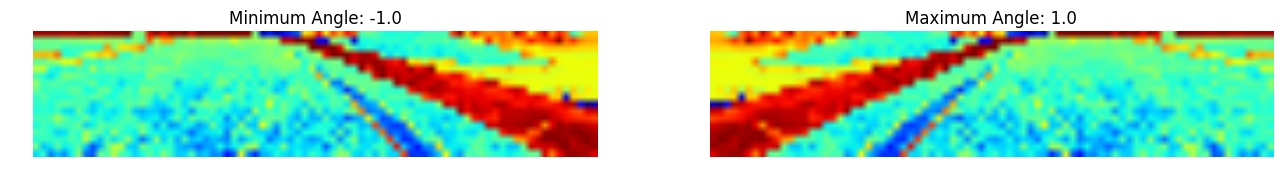

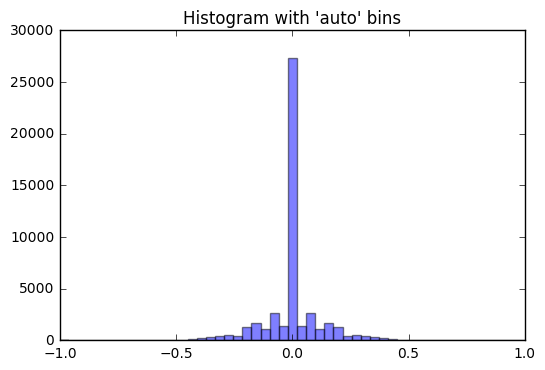

(array([  6.00000000e+00,   1.20000000e+01,   0.00000000e+00,
         0.00000000e+00,   3.00000000e+00,   3.00000000e+00,
         3.00000000e+00,   9.00000000e+00,   3.00000000e+00,
         1.80000000e+01,   2.40000000e+01,   3.00000000e+00,
         7.80000000e+01,   8.10000000e+01,   1.23000000e+02,
         2.07000000e+02,   3.12000000e+02,   4.38000000e+02,
         5.43000000e+02,   4.05000000e+02,   1.28400000e+03,
         1.67100000e+03,   1.11300000e+03,   2.66700000e+03,
         1.43100000e+03,   2.73420000e+04,   1.43100000e+03,
         2.66700000e+03,   1.11300000e+03,   1.67100000e+03,
         1.28400000e+03,   4.05000000e+02,   5.43000000e+02,
         4.38000000e+02,   3.12000000e+02,   2.07000000e+02,
         1.23000000e+02,   8.10000000e+01,   7.80000000e+01,
         3.00000000e+00,   2.40000000e+01,   1.80000000e+01,
         3.00000000e+00,   9.00000000e+00,   3.00000000e+00,
         3.00000000e+00,   3.00000000e+00,   0.00000000e+00,
         0.00000000e+00

In [13]:
plotRandomImage(features, labels)
plotMinMax(features, labels)
plotYHistorygram(labels)

## Preprocess training data


In [14]:
#Split the data into training/validation/testing sets here.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
    features, labels, test_size=0.10, random_state=42)

print('Shape of training images {}', X_train.shape)
print('Shape of validation images {}', X_test.shape)



#Shuffling training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

Shape of training images {} (43394, 18, 80, 1)
Shape of validation images {} (4822, 18, 80, 1)


In [15]:
# Get randomized datasets for training and validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=434339)

print('Shape of  train images {}', X_train.shape)
print('Shape of validation images {}', X_validation.shape)


Shape of  train images {} (32545, 18, 80, 1)
Shape of validation images {} (10849, 18, 80, 1)


In [16]:
# Print out shapes of new arrays
train_size = X_train.shape[0]
test_size = X_test.shape[0]
valid_size = X_validation.shape[0]
input_shape = X_train.shape[1:]
features_count = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

print("train size:", train_size)
print("valid size:", valid_size)
print("test size:", test_size)
print("input_shape:", input_shape)
print("features count:", features_count)

train size: 32545
valid size: 10849
test size: 4822
input_shape: (18, 80, 1)
features count: 1440


In [17]:
import pickle

# Save the data for easy access
pickle_file = 'camera.pickle'
stop = False

print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'train_dataset': X_train,
                'train_labels': y_train,
                'valid_dataset': X_validation,
                'valid_labels': y_validation,
                'test_dataset': X_test,
                'test_labels': y_test,
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')
stop = True

Saving data to pickle file...
Data cached in pickle file.
